In [1]:
from mesh import *

from VPINN_tri_final import *

from PROBDEF import PROBDEF

import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import logging; logging.getLogger('tensorflow').setLevel(logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

import gmsh_worker as gw
from MeshLib import MeshLib as ml

# importing probdef 
pb = PROBDEF()

2023-12-26 12:10:18.068053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 12:10:18.980641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



my_types lib imported

generate mesh lib imported

interpolator_lib imported

settings_lib imported 

MeshLib imported




In [2]:
# Get quad pairs
from numpy.polynomial import legendre

def get_quad_rule(n: int):
    # Degree of the Legendre polynomial (number of nodes - 1)

    # Nodes and weights for Gauss-Legendre quadrature
    nodes, weights = legendre.leggauss(n + 1)



    nodes=(nodes+1.0)/2.0


    # Nodes=np.array([nodes],dtype=np_type)

    Weights=np.array([weights],dtype=np_type)
    w = Weights.T @ Weights
    w = np.reshape(w, (-1,1))


    x, y =np.meshgrid(nodes,nodes)


    x = x.flatten()
    y = y.flatten()
 



    xy=np.array([x,y]).T


    return xy, w/4

def L2_error(xy, w):
    
    u_NN = vp.NN_imposeBC(xy)

    # Find the exact solution
    u_ex = pb.u_exact_np(xy[:,0], xy[:,1])
    u_ex = np.reshape(u_ex, (-1,1))

    integrand = (u_ex - u_NN)**2


    # Find the difference between exact and NN 
    # return (u_ex - u_NN)**2

    return np.sqrt(np.sum(w*integrand))

def semi_H1_error(xy, w):

    # Find the gradient of the exact solution
    grad_ex = np.array([pb.dudx(xy[:,0], xy[:,1]), pb.dudy(xy[:,0], xy[:,1])],dtype=np_type).T


    # Find the gradient of the NN solution
    grad_NN = vp.eval_grad_NN_BC(tf.constant(xy, dtype=tf_type))

    


    # Find the difference between exact and NN 
    pw_diff = grad_ex - grad_NN

    pw_diff = tf.reduce_sum(tf.square(pw_diff),axis=1)

    pw_diff=tf.reshape(pw_diff,(-1,1))


    return np.sqrt(np.sum(pw_diff*w))

In [3]:
def restart_model():
    model = tfk.models.Sequential()
    model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))
    return model

In [4]:
geo_file = './unit_square_triangles'
worker = gw.gmsh_worker(geo_file)
worker.generate_parallel_chain(False, False, False)

# seed for reproducibility
initializer = tf.keras.initializers.GlorotUniform(seed=1000)

# mesh init
domain = ((0, 0), (1, 0), (1, 1), (0, 1))

# order of test function 
N_test = 1
params = {'scheme': 'VPINNs','N_test':N_test}

xy, w = get_quad_rule(30)

H1 = []
L2 = []
semi = []
h = []

for refinement in [0,1,2,3]:
    model = restart_model()
    mesh, _ = ml.take_parallel_mesh_chain(worker.chain[refinement],worker.chain[-1], 'DDDD')
    mesh = mesh.convert_to_dict()
    vp=VPINN(pb,params,mesh,False,model)
    history=vp.train(15000, 0.0005)
    # ml.compare(worker.chain[refinement],worker.chain[refinement])


    L2_error_=L2_error(xy,w)


    semi_H1_err = semi_H1_error(xy,w)
    #H1_err = np.sqrt(L2_error**2 + semi_H1_err**2)

    #H1.append(H1_err)
    semi.append(semi_H1_err)
    L2.append(L2_error_)
    a, b = mesh['h_max'], mesh['h_min']
    h.append(0.5*a + 0.5*b)
    
    

2023-12-26 12:10:21.943790: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


-->mesh : 
     n_triangles :  4
     n_vertices  :  5
     n_edges     :  8
     h_max           :  1.0
     h_min           :  0.7071067811865476
-->test_fun      : 
     order       :  1
     dof         :  1


2023-12-26 12:10:46.748453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-26 12:10:46.752195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.7905848660 time: 2.4879701137542725
Iteration: 10 loss: 0.0211412887 time: 0.056490182876586914
Iteration: 20 loss: 0.0246921956 time: 0.054799795150756836
Iteration: 30 loss: 0.0097595312 time: 0.057351112365722656
Iteration: 40 loss: 0.0009980606 time: 0.05601000785827637
Iteration: 50 loss: 0.0020135766 time: 0.060976266860961914
Iteration: 60 loss: 0.0000700154 time: 0.05264425277709961
Iteration: 70 loss: 0.0001305067 time: 0.053154945373535156
Iteration: 80 loss: 0.0000919079 time: 0.05169939994812012
Iteration: 90 loss: 0.0000060521 time: 0.050173282623291016
Iteration: 100 loss: 0.0000021869 time: 0.045819997787475586
Iteration: 110 loss: 0.0000039338 time: 0.039420127868652344
Iteration: 120 loss: 0.0000013230 time: 0.03429603576660156
Iteration: 130 loss: 0.0000001163 time: 0.03215479850769043
Iteration: 140 loss: 0.0000000051 time: 0.03532147407531738
Iteration: 150 loss: 0.0000000326 time: 0.03364682197570801
Iteration: 160 loss: 0.0000000230 time: 0.02

2023-12-26 12:11:59.097286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-26 12:11:59.100971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.1100002730 time: 2.9545247554779053
Iteration: 10 loss: 0.0185641847 time: 0.09357953071594238
Iteration: 20 loss: 0.0104962785 time: 0.09421873092651367
Iteration: 30 loss: 0.0051915833 time: 0.0966343879699707
Iteration: 40 loss: 0.0016350525 time: 0.08510518074035645
Iteration: 50 loss: 0.0007420293 time: 0.08286881446838379
Iteration: 60 loss: 0.0004640379 time: 0.0824289321899414
Iteration: 70 loss: 0.0002519273 time: 0.09079885482788086
Iteration: 80 loss: 0.0001036577 time: 0.0850684642791748
Iteration: 90 loss: 0.0000461426 time: 0.08551955223083496
Iteration: 100 loss: 0.0000222299 time: 0.08413457870483398
Iteration: 110 loss: 0.0000113820 time: 0.07390999794006348
Iteration: 120 loss: 0.0000083684 time: 0.0738072395324707
Iteration: 130 loss: 0.0000075156 time: 0.07315444946289062
Iteration: 140 loss: 0.0000073169 time: 0.07073736190795898
Iteration: 150 loss: 0.0000073053 time: 0.07214236259460449
Iteration: 160 loss: 0.0000072769 time: 0.06914234161376

2023-12-26 12:14:08.366393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-26 12:14:08.371246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.0085826756 time: 9.013261318206787
Iteration: 10 loss: 0.0021162419 time: 0.18950939178466797
Iteration: 20 loss: 0.0012719658 time: 0.19253158569335938
Iteration: 30 loss: 0.0008170565 time: 0.192427396774292
Iteration: 40 loss: 0.0005867273 time: 0.1760876178741455
Iteration: 50 loss: 0.0005543954 time: 0.1840050220489502
Iteration: 60 loss: 0.0005322618 time: 0.18494534492492676
Iteration: 70 loss: 0.0005120517 time: 0.18655872344970703
Iteration: 80 loss: 0.0005017849 time: 0.18309593200683594
Iteration: 90 loss: 0.0004912078 time: 0.17968010902404785
Iteration: 100 loss: 0.0004804885 time: 0.17446446418762207
Iteration: 110 loss: 0.0004686886 time: 0.18153667449951172
Iteration: 120 loss: 0.0004554401 time: 0.17797255516052246
Iteration: 130 loss: 0.0004405032 time: 0.17516756057739258
Iteration: 140 loss: 0.0004236225 time: 0.17312932014465332
Iteration: 150 loss: 0.0004047164 time: 0.1858367919921875
Iteration: 160 loss: 0.0003839269 time: 0.1775095462799072

2023-12-26 12:19:14.619365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradient_tape/strided_slice_2/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_2/StridedSliceGrad/strides}}]]
2023-12-26 12:19:14.621438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradient_tape/strided_slice_3/StridedSliceGrad_grad/StridedSlice/gradient_tape/strided_slice_3/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{

Iteration: 0 loss: 0.0005437941 time: 32.22886109352112
Iteration: 10 loss: 0.0001489374 time: 0.3427770137786865
Iteration: 20 loss: 0.0000997782 time: 0.33704257011413574
Iteration: 30 loss: 0.0000636894 time: 0.3545658588409424
Iteration: 40 loss: 0.0000502882 time: 0.33411097526550293
Iteration: 50 loss: 0.0000482877 time: 0.3187592029571533
Iteration: 60 loss: 0.0000463916 time: 0.32625389099121094
Iteration: 70 loss: 0.0000446941 time: 0.3223001956939697
Iteration: 80 loss: 0.0000437834 time: 0.3200392723083496
Iteration: 90 loss: 0.0000428962 time: 0.32009291648864746
Iteration: 100 loss: 0.0000419218 time: 0.3280346393585205
Iteration: 110 loss: 0.0000408579 time: 0.33176279067993164
Iteration: 120 loss: 0.0000396645 time: 0.31200361251831055
Iteration: 130 loss: 0.0000383315 time: 0.3176259994506836
Iteration: 140 loss: 0.0000368416 time: 0.32559704780578613
Iteration: 150 loss: 0.0000352025 time: 0.32386159896850586
Iteration: 160 loss: 0.0000334505 time: 0.310361385345459
It

In [5]:
h = np.array(h)

#H1 = np.array(H1)
L2 = np.array(L2)
semi = np.array(semi)

semi rate: 2.864745033082956
L2 rate: 3.5142746404802128


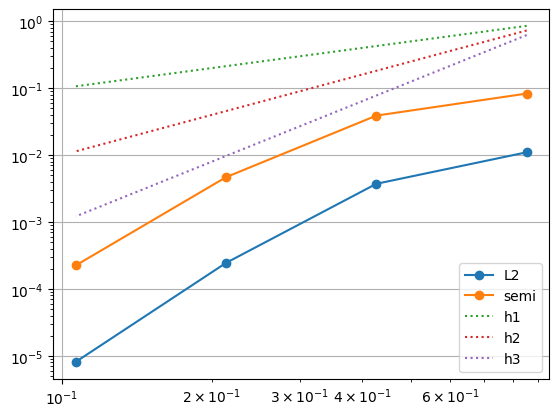

In [6]:
# slope_H1, intercept_H1 = np.polyfit(h, H1, 1)
# slope_L2, intercept_L2 = np.polyfit(h, L2, 1)

coeffs = np.polyfit(np.log10(h), np.log10(semi), 1)
polynomial = np.poly1d(coeffs)
log10_H1_fit = polynomial(np.log10(h))

print(f"semi rate: {coeffs[0]}")

coeffs = np.polyfit(np.log10(h), np.log10(L2), 1)
polynomial = np.poly1d(coeffs)
log10_L2_fit = polynomial(np.log10(h))

print(f"L2 rate: {coeffs[0]}")

#plt.loglog(h, H1, marker='o', label='H1')
plt.loglog(h, L2, marker='o', label='L2')
plt.loglog(h, semi, marker='o', label='semi')
#plt.loglog(h, 10**log10_H1_fit)
# plt.loglog(h, 10**log10_L2_fit)
plt.loglog(h, h, linestyle=':', label='h1')
plt.loglog(h, h*h, linestyle=':', label='h2')
plt.loglog(h, h*h*h, linestyle=':', label='h3')
plt.grid()
plt.legend()